# Implement Online portfolio algorithms directly into the Gym environment

In [22]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER

# from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2020-12-31'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER


# TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)

# No time window needed for PPO
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

raw_df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()


from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(raw_df)
portfolio_norm_df

df_train = portfolio_norm_df[(portfolio_norm_df["date"] >= TRAIN_START_DATE) & (portfolio_norm_df["date"] <= TRAIN_END_DATE)]
df_2021 = portfolio_norm_df[(portfolio_norm_df["date"] >= TEST_START_DATE) & (portfolio_norm_df["date"] <= "2021-12-31")]
df_2022 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2022-01-01") & (portfolio_norm_df["date"] <= "2022-12-31")]
df_2023 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2023-01-01") & (portfolio_norm_df["date"] < TEST_END_DATE)]

print(df_train)

# Pivot the DataFrame 
pivoted_df = df_train.pivot(index='date', columns='tic', values='close') 
# Calculate price ratios 
price_ratios = pivoted_df / pivoted_df.iloc[0]


print(price_ratios)


# import yfinance as yf
# # Download data from Yahoo Finance
# tickers = ['AAPL', 'MSFT', 'GOOGL'] 
# data = yf.download(tickers, start='2021-01-01', end='2023-01-01')['Close'] 
# # Calculate daily returns 
# returns = data.pct_change().dropna()

# print(returns)

# print(returns.values)

# dimensions = returns.values.shape 
# print("Dimensions of returns.values:", dimensions)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

Shape of DataFrame:  (107677, 8)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.31332941 0.43188074 0.33824661 ... 0.02556499 0.01810204 0.02266286]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5  0.75 1.   ... 0.5  0.75 1.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(


             date      open      high       low     close    volume   tic  \
0      2009-04-01  0.018773  0.019501  0.018834  0.016610  0.313329  AAPL   
1      2009-04-01  0.165873  0.164931  0.162829  0.121385  0.216841  AMGN   
2      2009-04-01  0.067544  0.073365  0.066315  0.059964  0.306650   AXP   
3      2009-04-01  0.077397  0.079819  0.077716  0.062400  0.089997    BA   
4      2009-04-01  0.092561  0.098663  0.092690  0.065151  0.243804   CAT   
...           ...       ...       ...       ...       ...       ...   ...   
85835  2020-12-31  0.621694  0.629081  0.625398  0.610391  0.056423   UNH   
85836  2020-12-31  0.829819  0.835024  0.832595  0.815849  0.017546     V   
85837  2020-12-31  0.936301  0.945034  0.945721  0.951571  0.020931    VZ   
85838  2020-12-31  0.405339  0.411100  0.405338  0.476550  0.091477   WBA   
85839  2020-12-31  0.856396  0.848947  0.852785  0.813464  0.073401   WMT   

        day  
0      0.50  
1      0.50  
2      0.50  
3      0.50  
4    

In [23]:
# def ulcer(r, rf_rate=0.0, freq=None):
#     """Compute Ulcer ratio."""
#     freq = freq or _freq(r.index)
#     rf = rf_rate / freq

#     # subtract risk-free rate
#     r = _sub_rf(r, rf)

#     # annualized excess return
#     mu = r.mean() * freq

#     # ulcer index
#     x = (1 + r).cumprod()

#     if isinstance(x, pd.Series):
#         drawdown = 1 - x / x.cummax()
#     else:
#         drawdown = 1 - x / np.maximum.accumulate(x)

#     return mu / np.sqrt((drawdown**2).mean())

In [24]:
import numpy as np
import pandas as pd
import scipy.optimize as optimize


# First lets test find the BCRP with stock data

def opt_weights(
    X,
    metric="return",
    max_leverage=1,
    rf_rate=0.0,
    alpha=0.0,
    freq: float = 252,
    no_cash=False,
    sd_factor=1.0,
    **kwargs,
):
    """Find best constant rebalanced portfolio with regards to some metric.
    :param X: Prices in ratios.
    :param metric: what performance metric to optimize, can be either `return` or `sharpe`
    :max_leverage: maximum leverage
    :rf_rate: risk-free rate for `sharpe`, can be used to make it more aggressive
    :alpha: regularization parameter for volatility in sharpe
    :freq: frequency for sharpe (default 252 for daily data)
    :no_cash: if True, we can't keep cash (that is sum of weights == max_leverage)
    """
    assert metric in ("return", "sharpe", "drawdown", "ulcer")
    assert X.notnull().all().all()

    x_0 = max_leverage * np.ones(X.shape[1]) / float(X.shape[1])
    if metric == "return":
        objective = lambda b: -np.sum(np.log(np.maximum(np.dot(X - 1, b) + 1, 0.0001)))
    # elif metric == "sharpe":
    #     objective = lambda b: -sharpe(
    #         np.log(np.maximum(np.dot(X - 1, b) + 1, 0.0001)),
    #         rf_rate=rf_rate,
    #         alpha=alpha,
    #         freq=freq,
    #         sd_factor=sd_factor,
    #     )
    elif metric == "drawdown":

        def objective(b):
            R = np.dot(X - 1, b) + 1
            L = np.cumprod(R)
            dd = max(1 - L / np.maximum.accumulate(L))
            annual_ret = np.mean(R) ** freq - 1
            return -annual_ret / (dd + alpha)

    if no_cash:
        cons = ({"type": "eq", "fun": lambda b: max_leverage - sum(b)},)
    else:
        cons = ({"type": "ineq", "fun": lambda b: max_leverage - sum(b)},)

    while True:
        # problem optimization
        res = optimize.minimize(
            objective,
            x_0,
            bounds=[(0.0, max_leverage)] * len(x_0),
            constraints=cons,
            method="slsqp",
            **kwargs,
        )

        # result can be out-of-bounds -> try it again
        EPS = 1e-7
        if (res.x < 0.0 - EPS).any() or (res.x > max_leverage + EPS).any():
            X = X + np.random.randn(1)[0] * 1e-5
            print("Optimal weights not found, trying again...")
            continue
        elif res.success:
            break
        else:
            if np.isnan(res.x).any():
                print("Solution does not exist, use zero weights.")
                res.x = np.zeros(X.shape[1])
            else:
                print("Converged, but not successfully.")
            break

    return res.x




bcrp_weights = opt_weights(price_ratios) 
# Output the results 
print("BCRP Weights:", bcrp_weights)

total = sum(bcrp_weights)
print("Sum of the list elements:", total)

BCRP Weights: [2.32829920e-09 8.21050701e-11 1.68075726e-08 1.83312243e-09
 1.08539383e-08 9.99999975e-01 2.29839878e-09 1.92321228e-09
 3.95264541e-09 5.48145205e-09 1.05166065e-18 2.24489606e-09
 4.81035220e-09 2.68678032e-09 1.23060219e-09 3.75635773e-09
 2.62443355e-09 9.88858359e-10 4.46595672e-09 1.69424242e-09
 9.24449035e-11 1.03690154e-09 2.68208068e-09 7.49170079e-10
 1.61883347e-17 3.09366247e-18 4.96332445e-10 3.04800984e-09
 3.50465629e-18]
Sum of the list elements: 1.000000052995878


In [ ]:
import numpy as np
import pandas as pd

from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback
from typing import Any, ClassVar, Dict, Iterable, List, Optional, Tuple, Type, TypeVar, Union

# TODO add refrences to the code: http://www-isl.stanford.edu/~cover/papers/paper93.pdf


class BCRPModel:
    def __init__(
            self, 
            env: Union[GymEnv, str],
            policy: Any, # Policy doesnt matter here
            device: str, # device doesnt matter here
            policy_kwargs: Optional[Dict[str, Any]] = None, # policy_kwargs doesnt matter here
            ) -> None:
        
        # Super simple algorithm, we only need the environment
        # This environment needs to have prices for the BCRP algorithm TODO check the type here

        assert env is not None 
        self.env = env

        # This portoflio cheats by pulling the full price range ange getting the best portfolio weights in hindsight
        self._full_hindsight_prices = self.env._df

        # Pull out the actions space dimensions for the portfolio
        self.action_space_shape = self.env.action_space.shape
        self.portfolio_length = self.action_space_shape[0]

        # Calculate the inital weights, for BCRP we use hinesight to get the best possible weights over the time range
        # Here we will cheat and calculate what the best weights would have been
        # This is obviously a benchmark metric and does not work in reality (because we can't see into the future)
        
        # Pivot the DataFrame 
        pivoted_df = self._full_hindsight_prices.pivot(index='date', columns='tic', values='close') 
        # Calculate price ratios 
        price_ratios = pivoted_df / pivoted_df.iloc[0]
        # Get the magic weights
        self.target_weights = np.array(opt_weights(price_ratios))
        # Assume no cash
        self.target_weights = np.insert(self.target_weights, 0, 0)

    def train(self) -> None:
        # TODO this model is derministic and doesnt learn anything, it only predicts
        pass

    def learn(
        self
    ):
        # TODO this model is derministic and doesnt learn anything, it only predicts
        pass

    def predict(
        self,
        observation: Union[np.ndarray, Dict[str, np.ndarray]],
        state: Optional[Tuple[np.ndarray, ...]] = None,
        episode_start: Optional[np.ndarray] = None,
        deterministic: bool = False, # TODO not needed this is always determininistic
    ) -> Tuple[np.ndarray, Optional[Tuple[np.ndarray, ...]]]:

        # TODO much of this comes from the policies class in stable baselines
        if isinstance(observation, tuple) and len(observation) == 2 and isinstance(observation[1], dict):
            raise ValueError(
                "You have passed a tuple to the predict() function instead of a Numpy array or a Dict. "
                "You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) "
                "vs `obs = vec_env.reset()` (SB3 VecEnv). "
                "See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 "
                "and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api"
            )
        
        # We always just return the target CRP weights
        actions = self.target_weights.reshape(1, self.portfolio_length)

        # The state doesnt matter here
        return actions, None

# TODO found this here:  https://github.com/Marigold/universal-portfolios/blob/master/universal/tools.py
def opt_weights(
    X,
    metric="return",
    max_leverage=1,
    rf_rate=0.0,
    alpha=0.0,
    freq: float = 252,
    no_cash=False,
    sd_factor=1.0,
    **kwargs,
):
    """Find best constant rebalanced portfolio with regards to some metric.
    :param X: Prices in ratios.
    :param metric: what performance metric to optimize, can be either `return` or `sharpe`
    :max_leverage: maximum leverage
    :rf_rate: risk-free rate for `sharpe`, can be used to make it more aggressive
    :alpha: regularization parameter for volatility in sharpe
    :freq: frequency for sharpe (default 252 for daily data)
    :no_cash: if True, we can't keep cash (that is sum of weights == max_leverage)
    """
    assert metric in ("return", "sharpe", "drawdown", "ulcer")
    assert X.notnull().all().all()

    x_0 = max_leverage * np.ones(X.shape[1]) / float(X.shape[1])
    if metric == "return":
        objective = lambda b: -np.sum(np.log(np.maximum(np.dot(X - 1, b) + 1, 0.0001)))
    # elif metric == "sharpe":
    #     objective = lambda b: -sharpe(
    #         np.log(np.maximum(np.dot(X - 1, b) + 1, 0.0001)),
    #         rf_rate=rf_rate,
    #         alpha=alpha,
    #         freq=freq,
    #         sd_factor=sd_factor,
    #     )
    elif metric == "drawdown":

        def objective(b):
            R = np.dot(X - 1, b) + 1
            L = np.cumprod(R)
            dd = max(1 - L / np.maximum.accumulate(L))
            annual_ret = np.mean(R) ** freq - 1
            return -annual_ret / (dd + alpha)

    if no_cash:
        cons = ({"type": "eq", "fun": lambda b: max_leverage - sum(b)},)
    else:
        cons = ({"type": "ineq", "fun": lambda b: max_leverage - sum(b)},)

    while True:
        # problem optimization
        res = optimize.minimize(
            objective,
            x_0,
            bounds=[(0.0, max_leverage)] * len(x_0),
            constraints=cons,
            method="slsqp",
            **kwargs,
        )

        # result can be out-of-bounds -> try it again
        EPS = 1e-7
        if (res.x < 0.0 - EPS).any() or (res.x > max_leverage + EPS).any():
            X = X + np.random.randn(1)[0] * 1e-5
            print("Optimal weights not found, trying again...")
            continue
        elif res.success:
            break
        else:
            if np.isnan(res.x).any():
                print("Solution does not exist, use zero weights.")
                res.x = np.zeros(X.shape[1])
            else:
                print("Converged, but not successfully.")
            break

    return res.x

In [26]:


MODELS = {"bcrp": BCRPModel}

class DRLStableAgent:
    """Implementation for DRL algorithms for portfolio optimization.

    Note:
        During testing, the agent is optimized through online learning.
        The parameters of the policy is updated repeatedly after a constant
        period of time. To disable it, set learning rate to 0.

    Attributes:
        env: Gym environment class.
    """

    def __init__(self, env):
        """Agent initialization.

        Args:
            env: Gym environment to be used in training.
        """
        self.env = env

    def get_model(
        self, model_name, device="cpu", model_kwargs=None, policy_kwargs=None
    ):
        """Setups DRL model.

        Args:
            model_name: Name of the model according to MODELS list.
            device: Device used to instantiate neural networks.
            model_kwargs: Arguments to be passed to model class.
            policy_kwargs: Arguments to be passed to policy class.

        Note:
            model_kwargs and policy_kwargs are dictionaries. The keys must be strings
            with the same names as the class arguments. Example for model_kwargs::

            { "lr": 0.01, "policy": EIIE }

        Returns:
            An instance of the model.
        """
        if model_name not in MODELS:
            raise NotImplementedError("The model requested was not implemented.")

        model = MODELS[model_name]
        model_kwargs = {} if model_kwargs is None else model_kwargs
        policy_kwargs = {} if policy_kwargs is None else policy_kwargs

        # add device settings
        model_kwargs["device"] = device
        #policy_kwargs["device"] = device

        # add policy_kwargs inside model_kwargs
        model_kwargs["policy_kwargs"] = policy_kwargs

        # TODO default to usethe MlpPolicy
        return model(env=self.env, policy="MlpPolicy", **model_kwargs)

    @staticmethod
    def train_model(model, env, episodes=1):
        """Trains portfolio optimization model.

        Args:
            model: Instance of the model.
            episoded: Number of episodes.

        Returns:
            An instance of the trained model.
        """
        max_steps = len(env._df['date'].unique())

        print("Max number of time steps in an episode: ", max_steps)

        model.learn(
            total_timesteps = max_steps * episodes # TODO fix this
        )
        return model

    @staticmethod
    def DRL_prediction(model, env, deterministic=True):
        """make a prediction and get results"""
        test_env, test_obs = env.get_sb_env()
        
        

        test_env.reset()
        max_steps = len(env._df['date'].unique())

        validation_assets = None
        validation_dates = None

        for i in range(max_steps):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            # print("HERE!!!!!!!")
            # print(action)
            # print(type(action))

            # Pull out the latest assets and dates
            validation_assets = env._asset_memory["final"]
            validation_dates = env._date_memory

            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)

            if dones[0]:
                print("hit end!")
                break
        
        return validation_assets, validation_dates

In [27]:


from finrl.meta.env_portfolio_optimization.env_portfolio_opt_stable import PortfolioOptStableEnv

environment = PortfolioOptStableEnv(
        df_train,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None
    )

BCRP_results = {
    "date": {},
    "training": {},
    "2021": {},
    "2022": {},
    "2023": {}
}


environment_2021 = PortfolioOptStableEnv(
    df_2021,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)


environment_2022 = PortfolioOptStableEnv(
    df_2022,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2023 = PortfolioOptStableEnv(
    df_2023,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)


# Training
agent_bcrp = DRLStableAgent(env = environment)
model_bcrp = agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment)
BCRP_results["training"] = environment._terminal_asset_memory["final"]
BCRP_results["date"] = environment._terminal_date_memory

# 2021
agent_bcrp = DRLStableAgent(env = environment_2021)
model_bcrp = agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_2021)
BCRP_results["2021"]["value"] = environment_2021._terminal_asset_memory["final"]
BCRP_results["2021"]["date"] = environment_2021._terminal_date_memory


# 2022
agent_bcrp = DRLStableAgent(env = environment_2022)
model_bcrp = agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_2022)
BCRP_results["2022"]["value"] = environment_2022._terminal_asset_memory["final"]
BCRP_results["2022"]["date"] = environment_2022._terminal_date_memory

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 27222868.0
Final accumulative portfolio value: 27.222868
Maximum DrawDown: -0.3881525691558484
Sharpe ratio: 0.9470188032700019
Total commission cost: 2.72383071098011
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1468927.5
Final accumulative portfolio value: 1.4689275
Maximum DrawDown: -0.11920608466149285
Sharpe ratio: 1.6518476238178994
Total commission cost: 4.161498509347439e-06
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1559244.5
Final accumulative portfolio value: 1.5592445
Maximum DrawDown: -0.24948924898395086
Sharpe ratio: 1.5210043595011347
Total commission cost: 8.149072527885437e-09
hit end!


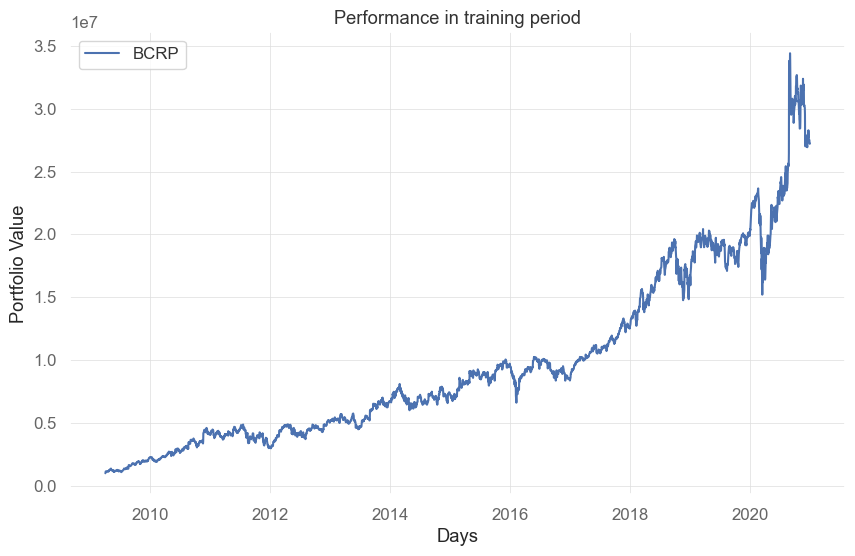

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(BCRP_results["date"], BCRP_results["training"], label="BCRP")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

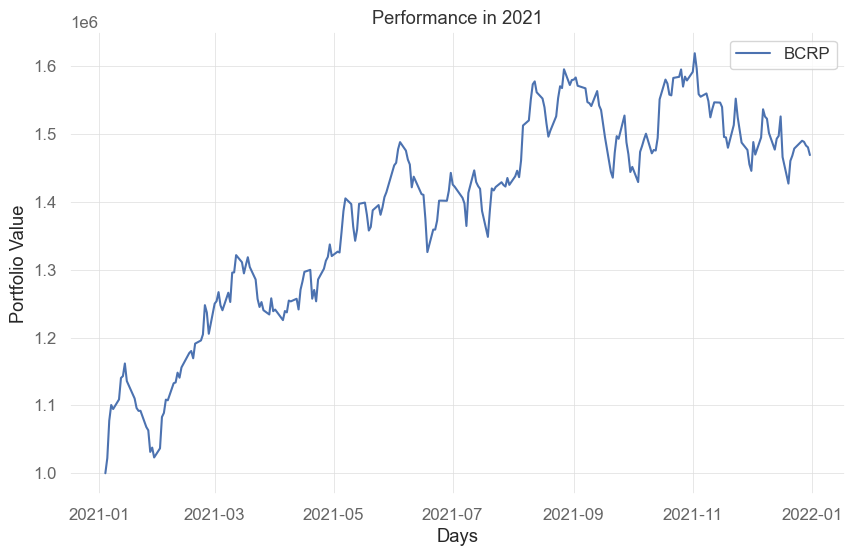

In [29]:
plt.plot(BCRP_results["2021"]["date"], BCRP_results["2021"]["value"], label="BCRP")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

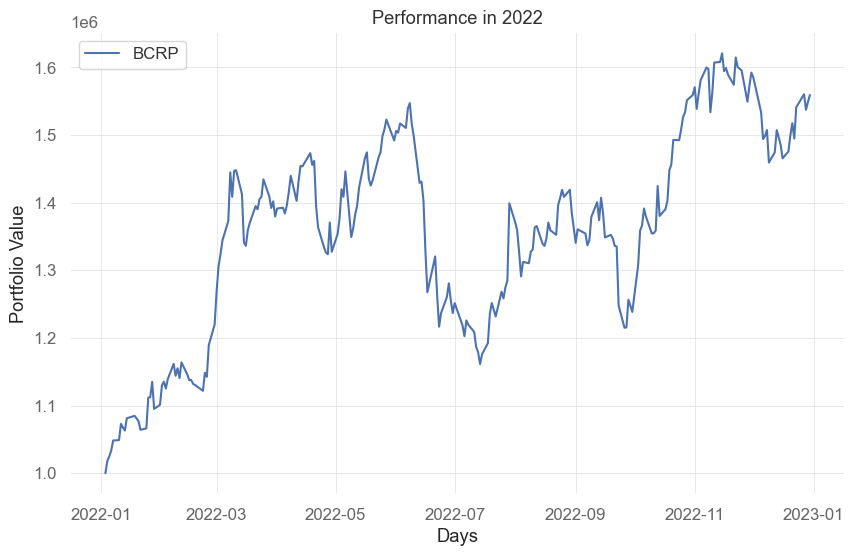

In [30]:
plt.plot(BCRP_results["2022"]["date"], BCRP_results["2022"]["value"], label="BCRP")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()